# `cloudwatcher` Python API usage

The purpose of this page is to provide a quick overview of the `cloudwatcher` Python API. The package consists of two user-facing classes:

- `MetricWatcher`: This class is used to interact with AWS CloudWatch metrics.
- `LogWatcher`: This class is used to interact with AWS CloudWatch logs.

Both of these classes inherit from the `CloudWatcher` class.

## `MetricWatcher`: convenient interface to AWS CloudWatch metrics

`MetricWatcher` can be used to interact with AWS CloudWatch metrics. 

### `MetricWatcher` initialization

As described in the Login credentials section, the AWS credentials can be sourced from environment variables: `AWS_ACCESS_KEY_ID`, `AWS_SECRET_ACCESS_KEY`, `AWS_SESSION_TOKEN`.
Alternatively, you can pass the values as arguments to the `MetricWatcher` constructor.

In [7]:
from cloudwatcher.metricwatcher import MetricWatcher
from cloudwatcher.preset import Dimension
from dotenv import load_dotenv
import os

load_dotenv()

instance_id = os.environ.get("INSTANCE_ID")
mw = MetricWatcher(
    namespace="NepheleNamespaceEC2",
    metric_name="mem_used",
    metric_id="mem_used",
    metric_unit="Bytes",
    dimensions_list=[Dimension(Name="InstanceId", Value=instance_id)],
)

### `MetricWatcher` presets

As you can see there are multiple arguments that can be passed to the `MetricWatcher` constructor. In order to improve the UX when using `MetricWatcher`. The `cloudwatcher` package provides a few presets that can be used to query the data reported by `CloudWatchAgent` within certain systems. Additionally, custom presets can be defined by the user and used in the same way.

Presets are JSON-formatted files that provide parameter bundles for `MetricWatcher` initialization.

#### Usage

Listing available presets:


In [8]:
from cloudwatcher.preset import PresetFilesInventory
from rich.console import Console

pfi = PresetFilesInventory()
Console().print(pfi.presets_table)


                 Presets available in: /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name                                   ┃ Path                                                                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ nephele_disk_used_percent              │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_di… │
│ nephele_mem_cached                     │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_me… │
│ nephele_mem                            │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_me… │
│ nephele_disk_used_percent_nephele_data │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_di… │
│ nephele_cpu_usage_user                 │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_cp… │
│ nephele_processes_dead                 │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_pr… │
│ nephele_swap_used_percent              │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_sw… │
│ nephele_swap_used                      │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_sw… │
└────────────────────────────────────────┴────────────────────────────────────────────────────────────────────────┘

Using a preset:

In [9]:
from cloudwatcher.preset import MetricWatcherSetup
mw_setup = MetricWatcherSetup.from_json(pfi.get_preset_path("nephele_mem"))
mw_setup.upsert_dimensions([f"InstanceId:{instance_id}"])
mw = MetricWatcher(**mw_setup.to_dict())
query_kwargs = {
    "days": 5,
    "hours": 0,
    "minutes": 0,
    "stat": "Maximum",
    "period": 60,
}
response = mw.query_ec2_metrics(**query_kwargs)





### Querying AWS CloudWatch metrics

In order to specify the EC2 instace query settings (period, granularity, etc.), the user would need to provide multiple parameters. To make it easier, there are a few sensible presets that can be used to select the query settings, which are passed to `query_ec2_metrics` method. These presets are defined to query the data reported by `CloudWatchAgent` within the last day, hour or minute.

The presets can be used by passing the `query_preset` argument to the functions presented below. Alternatively, users can pass `query_kwargs` argument, which overrides the preset values.

### Logging methods

There is a method that can be used to log the metric to the screen. The EC2 instance is automatically queried if the query response is not provided.

### File saving methods

There are number of methods that can be used to save the metric data to a file. Again, the EC2 instance is automatically queried if the query response is not provided.


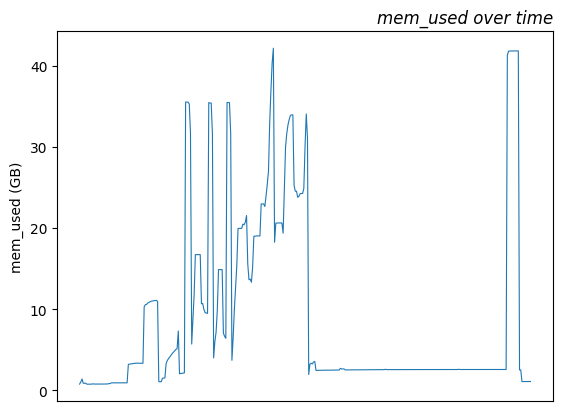

In [10]:
mw.save_metric_plot(file_path=f"/tmp/{instance_id}_plot.png", query_kwargs=query_kwargs)
mw.save_metric_csv(file_path=f"/tmp/{instance_id}_metric.csv", query_kwargs=query_kwargs)
mw.save_metric_json(file_path=f"/tmp/{instance_id}_metric.json", query_kwargs=query_kwargs)
mw.save_response_json(file_path=f"/tmp/{instance_id}_response.json", query_kwargs=query_kwargs)

### Manual EC2 querying

For users that require more control over the EC2 instance query settings, the `query_ec2_metrics` method can be used to manually query the EC2 instance. For instance it allows to fine tune the query period settings.

In [11]:
FINE_TUNED_SETTINGS = {
    "days": 5,
    "hours": 0,
    "minutes": 0,
    "stat": "Maximum",
    "period": 60,
}
response = mw.query_ec2_metrics(**FINE_TUNED_SETTINGS)

response["ResponseMetadata"]

{'RequestId': 'bb3880e0-17e6-45d2-a007-a7b797c6d52f',
 'HTTPStatusCode': 200,
 'HTTPHeaders': {'x-amzn-requestid': 'bb3880e0-17e6-45d2-a007-a7b797c6d52f',
  'content-type': 'text/xml',
  'content-length': '33663',
  'date': 'Tue, 08 Nov 2022 16:46:07 GMT'},
 'RetryAttempts': 0}

### `TimedMetric` dataclass

Internally, the package uses `TimedMetric` dataclass to store the metric data. This dataclass is used to store the metric data and provide a convenient interface to access the data. It can be also used to interact with the metric data by the user.

In [12]:
response = mw.query_ec2_metrics(**FINE_TUNED_SETTINGS)
timed_metric = mw.timed_metric_factory(response)[0]
print(timed_metric.__class__)
timed_metric.values[1:10]

<class 'cloudwatcher.metric_handlers.TimedMetric'>


[1173819392.0,
 1172045824.0,
 1171132416.0,
 1170399232.0,
 1170014208.0,
 1168662528.0,
 1168093184.0,
 2711384064.0,
 2704683008.0]

## `LogWatcher`: convenient interface to AWS CloudWatch logs

`LogWatcher` can be used to interact with AWS CloudWatch logs.

_Coming soon..._